# Functions

For the other packages in this module, see [this notebook](./Using&#32;the&#32;Functions&#32;Module.ipynb).

## LL_secular

- Functions in this package:
    1. A_jj
    1. A_jk
    1. B_jj
    1. B_jk
    1. A_matrix
    1. B_matrix
    1. g_eigenfreqs
    1. f_eigenfreqs
    1. A
    1. A_j
    1. B
    1. B_j
    1. max_forced_e
    1. max_inner_e
    1. max_e_3planets
    1. e_tmax_3planets
    1. max_forced_i

This package codes up the equations of Laplace-Lagrange theory set forth in Chapter 7 of Murray & Dermott 1999 (MD99) for point masses.

In [109]:
import LL_secular

import numpy as np
from astropy import units as u
from Functions.orbits import PtoA
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import optimize

In [110]:
#simplified system based on outer solar system
masses = np.array([1 *u.Msun/u.Mjupiter,1,.3,.046,.054]) * u.Mjupiter
periods = np.array([4331,10747,30589,59800]) * u.day
smas = PtoA(masses,periods)

In [111]:
#A_jj finds the [j,j] entry in the A matrix (associated with the eccentricity-pericenter)
#see eqn 7.132 of MD99 (no J terms because point masses)

A_22 = LL_secular.A_jj(2,masses,periods)

#A_jk finds the [j,k] entry in the A matrix (associated with the eccentricity-pericenter)
#see eqn 7.133 of MD99 (no J terms because point masses)

A_24 = LL_secular.A_jk(2,4,masses,periods)

print(A_22)
print(A_24)

2.478968766497359e-07 rad / d
-3.506541534690852e-10 rad / d


In [112]:
#B_jj finds the [j,j] entry in the B matrix (associated with the inclination-node)
#see eqn 7.134 of MD99 (no J terms because point masses)

B_22 = LL_secular.B_jj(2,masses,periods)

#B_jk finds the [j,k] entry in the B matrix (associated with the inclination-node)
#see eqn 7.135 of MD99 (no J terms because point masses)

B_24 = LL_secular.B_jk(2,4,masses,periods)

print(B_22)
print(B_24)

-2.478968766497359e-07 rad / d
8.924864883041837e-10 rad / d


In [113]:
#A_matrix constructs the entire (N,N) A matrix
A_full = LL_secular.A_matrix(masses,periods)

#B_matrix constructs the entire (N,N) B matrix
B_full = LL_secular.B_matrix(masses,periods)

print(A_full)
print(B_full)

[[ 1.00042949e-07 -6.45070759e-08 -3.72181777e-10 -6.74402220e-11]
 [-1.58896047e-07  2.47896877e-07 -2.44651624e-09 -3.50654153e-10]
 [-4.21957243e-09 -1.12604489e-08  3.68904563e-08 -4.23438389e-09]
 [-5.20893445e-10 -1.09952004e-09 -2.88474074e-09  9.03969016e-09]] rad / d
[[-1.00042949e-07  9.86251756e-08  1.10616400e-09  3.11609092e-10]
 [ 2.42936924e-07 -2.47896877e-07  4.06746630e-09  8.92486488e-10]
 [ 1.25410200e-08  1.87211087e-08 -3.68904563e-08  5.62832757e-09]
 [ 2.40680010e-09  2.79850323e-09  3.83438683e-09 -9.03969016e-09]] rad / d


In [114]:
#g_eigenfreqs finds the N eigenfrequencies of the A matrix
gfreqs = LL_secular.g_eigenfreqs(masses,periods)

#f_eigenfreqs finds the N-1 eigenfrequencies of the B matrix
ffreqs = LL_secular.f_eigenfreqs(masses,periods)

print(gfreqs)
print(ffreqs)

[2.99394867e-07 4.95742570e-08 3.63156202e-08 8.58522753e-09] rad / d
[-3.45602963e-07 -3.90818470e-08 -9.18516221e-09] rad / d


In [115]:
#simplified system based on outer solar system gas giants only
masses2 = np.array([1 *u.Msun/u.Mjupiter,1,.3]) * u.Mjupiter
periods2 = np.array([4331,10747]) * u.day
smas2 = PtoA(masses2,periods2)

In [116]:
#A finds the A from eqn 7.55 of MD99
#this is for a very specific scenario with 2 planets and a test particle
#for this function, the inputs must be in the required units (AU and Mjupiter) but no explicit astropy units
#the smas input must have the test particle as the first entry regardless of its location

A_1AUtp = LL_secular.A([1,*smas2.value],masses2.value)
A_7AUtp = LL_secular.A([7,*smas2.value],masses2.value)
A_20AUtp = LL_secular.A([20,*smas2.value],masses2.value)

print(A_1AUtp)
print(A_7AUtp)
print(A_20AUtp)

9.827627318703674e-08 rad / d
2.039115042451278e-06 rad / d
2.5870328755745382e-08 rad / d


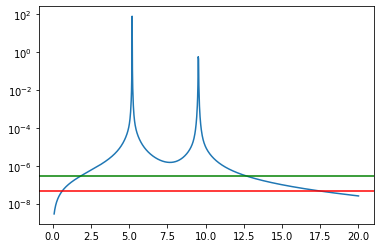

In [117]:
#A can be used to calculate the test particle frequency for comparison with eigenfrequencies
#this determines the location of secular resonances in linear theory
tp_smas = np.linspace(.1,20,num=1000)
gfreqs2 = LL_secular.g_eigenfreqs(masses2,periods2)
A_tp = [LL_secular.A([a,*smas2.value],masses2.value).value for a in tp_smas]

#visualize the idea
plt.plot(tp_smas,A_tp)
plt.axhline(gfreqs2[0].value,color='r')
plt.axhline(gfreqs2[1].value,color='g')
plt.yscale('log')

0.6241013222994198


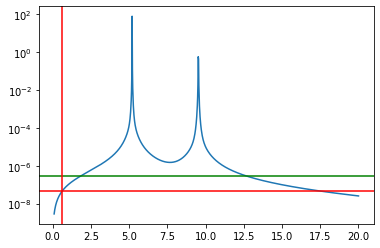

In [118]:
#to actually numerical solve for the location of the resonances, I use scipy.optimize.minimize_scalar
#using a dummy function to minimize the difference between the eigenfrequency and the test particle frequency
def A_scalar(a,a1,a2,m1,m2,Mstar,g):
    SMA = [a,a1,a2]
    Ms = [Mstar,m1,m2]
    dum = LL_secular.A(SMA,Ms)
    return abs(dum-g).value
g1,g2 = gfreqs2
a1,a2 = smas2.value
Mstar,m1,m2 = masses2.value
#there are 4 different eccentricity-pericenter secular resonances I could solve for
#here I solve for the interior resonance for g1
ares1_g1 = optimize.minimize_scalar(A_scalar,method='bounded',
                                    bounds=(.01*a1,a1),args=(a1,a2,m1,m2,Mstar,g1))['x']
print(ares1_g1)

#double-check via visualizing -- the red lines should cross on top of the blue line
plt.plot(tp_smas,A_tp)
plt.axhline(gfreqs2[0].value,color='r')
plt.axhline(gfreqs2[1].value,color='g')
plt.axvline(ares1_g1,color='r')
plt.yscale('log')

In [119]:
#A_j finds the A_j from eqn 7.56 of MD99
#this is used by the forced eccentricity function

A_1_tp1AU = LL_secular.A_j(1,smas2[0].value,masses2[0].value,masses2[1].value)
A_2_tp7AU = LL_secular.A_j(7,smas2[1].value,masses2[0].value,masses2[2].value)

print(A_1_tp1AU)
print(A_2_tp7AU)

-2.2464928564851587e-08 rad / d
-2.9089281311267954e-07 rad / d


In [120]:
#B finds the B from eqn 7.57 of MD99
#this is for a very specific scenario with 2 planets and a test particle
#for this function, the inputs must be in the required units (AU and Mjupiter) but no explicit astropy units
#the smas input must have the test particle as the first entry regardless of its location

B_1BUtp = LL_secular.B([1,*smas2.value],masses2.value)
B_7BUtp = LL_secular.B([7,*smas2.value],masses2.value)
B_20BUtp = LL_secular.B([20,*smas2.value],masses2.value)

print(B_1BUtp)
print(B_7BUtp)
print(B_20BUtp)

#you may notice that B = -A, this is expected

-9.827627318703674e-08 rad / d
-2.039115042451278e-06 rad / d
-2.5870328755745382e-08 rad / d


12.420136358593163


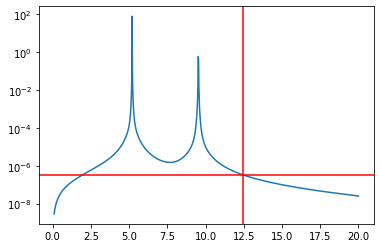

In [121]:
#similarly, we can find the secular resonance locations
#this time there is only 1 eigenfrequency so only 2 resonances

tp_smas = np.linspace(.1,20,num=1000)
ffreqs2 = LL_secular.f_eigenfreqs(masses2,periods2)[0]
B_tp = np.array([LL_secular.B([a,*smas2.value],masses2.value).value for a in tp_smas])

def B_scalar(a,a1,a2,m1,m2,Mstar,f):
    SMA = [a,a1,a2]
    Ms = [Mstar,m1,m2]
    dum = LL_secular.B(SMA,Ms)
    return abs(dum-f).value

a1,a2 = smas2.value
Mstar,m1,m2 = masses2.value

#this time I find the exterior resonance
ares2_f = optimize.minimize_scalar(B_scalar,method='bounded',
                                    bounds=(1.001*a2,20*a2),args=(a1,a2,m1,m2,Mstar,ffreqs2))['x']
print(ares2_f)

#double-check via visualizing -- the red lines should cross on top of the blue line
#plotting abs value so that we can use log scale
plt.plot(tp_smas,abs(B_tp))
plt.axhline(abs(ffreqs2.value),color='r')
plt.axvline(ares2_f,color='r')
plt.yscale('log')

In [122]:
#B_j finds the B_j from eqn 7.58 of MD99
#this is used by the forced inclination function

B_1_tp1AU = LL_secular.B_j(1,smas2[0].value,masses2[0].value,masses2[1].value)
B_2_tp7AU = LL_secular.B_j(7,smas2[1].value,masses2[0].value,masses2[2].value)

print(B_1_tp1AU)
print(B_2_tp7AU)

#note that B_j != -A_j

9.392019600194858e-08 rad / d
3.452228848723084e-07 rad / d


In [123]:
#max_forced_e finds the max e of a test particle over 10^9 orbits
#only with 2 massive planets
#this uses the process from section 7 MD99

#simplified system based on Jup/Sat + Earth as a test particle (m=0)
masses = np.array([1 *u.Msun/u.Mjupiter,0,1,.3]) * u.Mjupiter
periods = np.array([365,4331,10747]) * u.day
smas = PtoA(masses,periods)

eccs = np.array([0.049,.052])
poms = np.array([2.01,3.60])

max_Earth_e = LL_secular.max_forced_e(masses,smas,eccs,poms)

print(max_Earth_e)

0.019835823924636363


In [124]:
#max_inner_e finds the max e of the inner planet over 10^9 orbits
#for a 3-planet system

#simplified system based on Jup/Sat + Earth (not a test particle)
masses = np.array([1 *u.Msun/u.Mjupiter,1*u.Mearth/u.Mjupiter,1,.3]) * u.Mjupiter
periods = np.array([365,4331,10747]) * u.day
smas = PtoA(masses,periods)

eccs = np.array([.017,0.049,.052])
poms = np.array([1.60,2.01,3.60])

max_Earth_e = LL_secular.max_inner_e(masses,smas,eccs,poms)

print(max_Earth_e)

0.03404278568379994


In [125]:
#max_e_3planets finds the max e of each planet over 10^9 orbits
#for a 3-planet system
#also provides the ecc of the other 2 planets at the point in time when 1 planet is at emax

all_eccs_output = LL_secular.max_e_3planets(masses,smas,eccs,poms)

#max eccs are in the first column of each row
max_Earth_e = all_eccs_output[0,0]
max_Jup_e = all_eccs_output[1,0]
max_Sat_e = all_eccs_output[2,0]

print(max_Earth_e,max_Jup_e,max_Sat_e)

#remaining eccs in order in the rest of row
Jup_e_at_max_Earth_e = all_eccs_output[0,1]
Sat_e_at_max_Earth_e = all_eccs_output[0,2]

Earth_e_at_max_Jup_e = all_eccs_output[1,1]
Sat_e_at_max_Jup_e = all_eccs_output[1,2]

Earth_e_at_max_Sat_e = all_eccs_output[2,1]
Jup_e_at_max_Sat_e = all_eccs_output[2,2]

print('at max Earth e: e_E',max_Earth_e,'e_J',Jup_e_at_max_Earth_e,'e_S',Sat_e_at_max_Earth_e)

0.03404236060537911 0.057879816844540986 0.08510924130563456
at max Earth e: e_E 0.03404236060537911 e_J 0.023631878815498886 e_S 0.08508607364308698


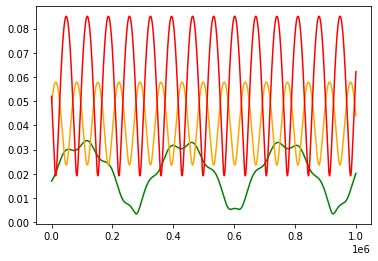

In [126]:
#e_tmax_3planets finds the e over time of each planet up to specified tmax (in years)
#10,000 steps
#for a 3-planet system

eccs_output = LL_secular.e_tmax_3planets(masses,smas,eccs,poms,1e6)

times = np.linspace(0,1e6,num=10000)

plt.plot(times,eccs_output[0],color='green') #Earth
plt.plot(times,eccs_output[1],color='orange') #Jupiter
plt.plot(times,eccs_output[2],color='red') #Saturn

In [127]:
#max_forced_i finds the max i of a test particle over 10^9 orbits
#only with 2 massive planets
#this uses the process from section 7 MD99

#simplified system based on Jup/Sat + Earth as a test particle (m=0)
masses = np.array([1 *u.Msun/u.Mjupiter,0,1,.3]) * u.Mjupiter
periods = np.array([365,4331,10747]) * u.day
smas = PtoA(masses,periods)

incs = np.array([0.023,0.043])
Oms = np.array([1.76,1.98])

max_Earth_i = LL_secular.max_forced_i(masses,smas,incs,Oms)

print(max_Earth_i)

0.030691116574800618


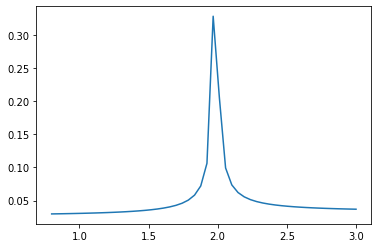

In [128]:
#for example, move the Earth's location to see how that affects its forced inclination

Earth_smas = np.linspace(.8,3)
Earth_max_incs = np.empty(len(Earth_smas))

for i,aE in enumerate(Earth_smas):
    smas[0] = aE*u.AU
    Earth_max_incs[i] = LL_secular.max_forced_i(masses,smas,incs,Oms)

plt.plot(Earth_smas,Earth_max_incs)

Text(0.5, 0, '$a_\\oplus$ (AU)')

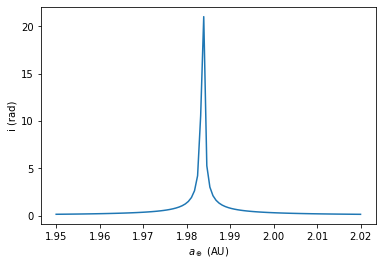

In [129]:
#zoom in to better resolve the secular resonance!

Earth_smas = np.linspace(1.95,2.02,num=100)
Earth_max_incs = np.empty(len(Earth_smas))

for i,aE in enumerate(Earth_smas):
    smas[0] = aE*u.AU
    Earth_max_incs[i] = LL_secular.max_forced_i(masses,smas,incs,Oms)

plt.plot(Earth_smas,Earth_max_incs)